In [1]:
!python -m spacy download en



    100% |████████████████████████████████| 52.2MB 75.9MB/s ta 0:00:011 2% |▉                               | 1.4MB 3.0MB/s eta 0:00:17
    100% |████████████████████████████████| 92kB 10.4MB/s a 0:00:011
  Running setup.py install for en-core-web-sm ... done
  Found existing installation: requests 2.12.4
    Uninstalling requests-2.12.4:
      Successfully uninstalled requests-2.12.4

    Linking successful

    /srv/app/venv/lib/python3.6/site-packages/en_core_web_sm/en_core_web_sm-1.2.0
    --> /srv/app/venv/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en').



In [65]:
from datascience import *
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.utils import shuffle
import spacy
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from matplotlib import *
%matplotlib inline

In [3]:
nlp = spacy.load('en', parser=False)

# Importing the Tables

First, we need to import the tables we'll be using. The first table, labeled **game_data**, was obtained from the webside *boardgamecapital.com*. The second table, labeled **rio_data**, was obtained from Rio Grande Games. We'll combine the two tables into game_data, this will be our primary data table.

In [4]:
game_data = Table.read_table('board-game-capital-text.csv').select('title', 'rules_text','price', 'time', 'age', 'players').relabeled(['age', 'rules_text','time', 'title', 'price', 'players'], ['Age', 'Text','Time', 'Title', 'Price', 'Players'])
ratings = Table.read_table('game_data_with_bgg.csv').select('Title','avgweight').relabeled('avgweight', 'Complexity')
rio_data = Table.read_table('rio-games.csv').select('Title', 'Text','age_range', 'players_range', 'MSRP', 'Length').relabeled(['MSRP', 'Length', 'age_range', 'players_range'], ['Price','Time','Age', 'Players'])
rio_data = rio_data.select('Title', 'Text','Price', 'Time', 'Age', 'Players')
game_data = game_data.append(rio_data)
game_data.append_column('Max Players', 0)
game_data.append_column('Max Age', 0)
game_data.select('Title', 'Text', 'Time', 'Players', 'Max Players', 'Age', 'Max Age', 'Price')
game_data = game_data.group('Title', max).relabeled(['Text max', 'Time max', 'Age max', 'Players max', 'Max Players max', 'Max Age max', 'Price max'], ['Text', 'Time', 'Age', 'Players', 'Max Players', 'Max Age', 'Price'])
game_data.show(5)

Title,Text,Price,Time,Age,Players,Max Players,Max Age
10 Days in the USA Rules,¢ 2-4 Players * Ages 10 to Adult ¢ 20-3 ...,13,30 min,8+,2 - 4,0,0
13 Dead End Drive Rules,.Assembly For all assembly instructions>see the ...,25,30 - 45 min.,10+,2 - 4,0,0
20 Questions Rules,20 Questions Game« Instructions Contents e 20 Ques ...,25,30 min.,8+,3-4,0,0
20th Century,"fi In the 20th Century, every region stri ...",59.95,0,12+,3-5,0,0
30 Seconds Rules,rules US.qxd 9/29/08 2:52 PM Page 1 thinking fas ...,17,30 min.,12+,3 - 16,0,0


In [5]:
ratings.show(5)

Title,Complexity
Pictionary Rules,1.254
Pictionary Rules,1.254
Pictionary Rules,1.254
Elfenland Rules,2.1642
Monopoly Rules,1.6816


## Reformatting the Cells

Next, we need to reformat the cells of this table to have uniform format. We will write several functions to reformat time strings into integers of minutes, and to find the minimum and maximum ages and number of players the game can take. In cases where there is no maximum, we will use the value 99 instead.

First, we'll write a function, called **time_formatter**, which will take a string. This function will convert string minute and hour values into integers in minutes. For example, a string "1 hour" would return 60.

In [6]:
#A function to reformat time strings into integers. Measured in minutes.
def time_formatter(string):
    string = string.replace("+","").replace(".","").lower()
    if "-" in string:
        string = string[5:]
    if "min" in string:
        string = string.replace("min","")
        string = int(string)
        return string
    elif "hours" or "hr" or "hour" in string:
        string = string.replace("hours","").replace("hr", "").replace("hour", "")
        string = int(string)
        return string*60
    else:
        return int(string)

We also have two pieces of data currently expressed as ranges. We will write two functions, **find_min** and **find_max**, to identify the minimum and maximum values of these ranges. If there is no maximum (i.e. age is 13+), we will substitute the value of 99.

In [7]:
# A function to find the minumum of an interval string.
def find_min(string):
    string = str(string)
    string = string.replace("+","")
    if "-" in string:
        return int(string[0])
    else:
        return int(string)

# A function to find the maximum of an interval string.
def find_max(string):
    string = str(string)
    if "+" in string:
        return int(99)
    elif "-" in string:
        return int(string[-1])
    else:
        return int(string)

To make best use of the text, we want to verify that we are only using tokens which are actually english words (as opposed to poor OCR expressions, misspellings, bar codes, etc.). 

In [8]:
#A function to clean up rules text.
def clean_up(string):
    my_string = ""
    working_string = nlp(string.strip())
    for word in range(len(working_string)):
        if (working_string[word].is_alpha) and (working_string[word].is_stop == False):
            my_string += str(working_string[word].lower_) + " "
    return my_string

Next, we'll iterate over all of the data in each table to convert the values using the functions we've defined. We'll add these values to empty lists, which will then be added to each table as a column. 

In [9]:
#Iterate through the data in game_data and reformat in each column.
for i in range(game_data.num_rows):
    game_data.append([game_data.column('Title').item(i), clean_up(game_data.column('Text').item(i)), 
                      int(game_data.column('Price').item(i)), time_formatter(game_data.column('Time').item(i)),  
                      find_min(game_data.column('Players').item(i)), find_max(game_data.column('Players').item(i)),
                      find_min(game_data.column('Age').item(i)), find_max(game_data.column('Age').item(i)) ])
game_data = game_data.take[int((game_data.num_rows)/2):]

In [10]:
game_data = ratings.join('Title', game_data)
game_data = game_data.relabeled(['Age','Players', 'Max Players'], ['Min Players', 'Max Players', 'Min Age'])

In [11]:
game_data = game_data.where('Complexity', are.above(0))
game_data.show(10)

Title,Complexity,Text,Price,Time,Min Players,Max Players,Min Age,Max Age
10 Days in the USA Rules,1.4096,players ages adult minutes game box state tiles tile sta ...,13,30,2,4,8,99
13 Dead End Drive Rules,1.4091,assembly instructions separate assembly instruction book ...,25,45,2,4,10,99
20 Questions Rules,1.3396,questions game instructions contents e game cards cards ...,25,30,3,4,8,99
20th Century,2.9612,fi century region strives develop improve way financial ...,59,0,3,5,12,99
30 Seconds Rules,1.2222,rules pm page thinking rules game neo description game p ...,17,30,3,6,12,99
5th Avenue Rules,2,board especially players course players choose play game ...,20,60,2,4,12,99
A Castle For All Seasons Rules,2.7985,g wn s ras contents page contents object game game mater ...,45,60,2,4,10,99
A Castle for all Seasons,2.7985,g wn s ras contents page contents object game game mater ...,54,0,2,4,10,99
A Dog's Life Rules,1.8333,dog life game manual players minutes years game christop ...,50,40,2,6,6,99
A Fool's Fortune,2.5,cards fortunes characters setting stage field stage hand ...,19,0,2,0,13,99


## Understanding the Variables

How might the data we've collected reflect the difficulty of a particular board game?

### Price

Game prices are often directly related to a variety of factors: number of pieces, quality of original art, intricacy of pieces and board, rarity in production, and length of play. Therefore, a higher price will indicate a more complex game.

### Time

Longer games are generally more complex. The longer a game takes to play, the more difficult it is to set up and to play through. The issue with this variable is that the games taken from Rio Grande Games did not have explicit time values. Therefore, a higher time value will indicate a more complex game.

### Minimum Number of Players

Games with lower player minimums are generally more complex (however, there are many exceptions to this). Party games, which require a higher minumum (usually 3-4 players) are less complex than campaign or strategy games, which are usually playable with just 2 players, and sometimes only with one. Therefore, a lower minimum player count will indicate a more complex game.

### Maximum Number of Players

Games which have higher player maximums are often less complex because they don't require pieces or game components to support large numbers of players. Therefore, a lower player maximum count will indicate a more complex game.

### Minimum Age

Games with a higher age minimum will generally be considered more complex.

### Maximum Age

Games with a higher age maximum will generally be considered more complex.

## Classification

We will use the technique of classification to find correlation coefficients for the strength of regression of the text of the instructions on an independent variable, specitically complexity. 

Using the ratings from Board Game Geek, a popular and respected website for board game information, we will attempt to train the classifier to identify a game as "easy," "medium," or "hard" based on the instructions in the text.

We need training and testing data to build and test our model. We will randomly assign 50 games to be training data, and the rest will be testing data.

In [12]:
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))])

In [13]:
def numToWords(num,join=True):
    if int(num) == 3600:
        num = 360
    '''words = {} convert an integer number into words'''
    num = int(num)
    units = ['','one','two','three','four','five','six','seven','eight','nine']
    teens = ['ten','eleven','twelve','thirteen','fourteen','fifteen','sixteen', \
             'seventeen','eighteen','nineteen']
    tens = ['','ten','twenty','thirty','forty','fifty','sixty','seventy', \
            'eighty','ninety']
    if num==0:
        return 'zero'
    if num<100:
        if num<10:
            return units[num]
        elif num<20:
            return teens[num-10]
        else:
            u = num % 10
            t = (num-u)/10
            str = tens[int(t)] + "-" + units[int(u)]
            return str
    else:
        tens = num % 100
        h = (num-tens)/100
        return units[int(h)] + "-hundred " + numToWords(tens)

In [14]:
meta_strings = []
for i in range(game_data.num_rows):
    player_range = "for " + numToWords(game_data['Min Players'][i]) + " to " + numToWords(game_data['Max Players'][i]) + " players"
    age_range = "for ages " + numToWords(game_data['Min Age'][i]) + " to " + numToWords(game_data['Max Age'][i])
    price_classification = "this game costs " + numToWords(game_data['Price'][i]) + " dollars"
    time = "this game takes " + numToWords(game_data['Time'][i]) + " minutes to play"
    meta_strings.append(player_range + "  " + age_range + "  " + price_classification + "   " + time)

In [15]:
for i in range(game_data.num_rows):
    game_data['Text'][i] = game_data['Text'][i] + meta_strings[i]

In [16]:
np.random.seed(10)
text_train = game_data.split(300)[0] #Split the data 
text_train_data = text_train['Text'] #text entries in the training set
text_train_target_price = text_train['Price']
text_train_target_complexity = text_train['Complexity']

We'll write some classifier functions to take the numerical values of price and complexity and convert them to bin classifications.

In [17]:
def price_classifier(value):
    if value < 20:
        return "cheap"
    elif value < 30:
        return "affordable"
    elif value < 40:
        return "pricey"
    else:
        return "expensive"
        
def complexity_classifier(value):
    if value < 2:
        return "easy"
    elif value < 3:
        return "medium"
    else:
        return "hard"

In [18]:
text_train_target_price = [price_classifier(value) for value in text_train_target_price]
text_train_target_complexity = [complexity_classifier(value) for value in text_train_target_complexity]

In [19]:
text_test = game_data.split(300)[1]
text_test_titles = text_test['Title']
text_test_data = text_test['Text']
text_test_target_price = text_test['Price']
text_test_target_complexity = text_test['Complexity']

In [20]:
text_test_target_price = [price_classifier(value) for value in text_test_target_price]
text_test_target_complexity = [complexity_classifier(value) for value in text_test_target_complexity]

In [21]:
text_clf.fit(text_train_data, text_train_target_price)
predicted = text_clf.predict(text_test_data)
np.mean(predicted == text_test_target_price)

0.78894472361809043

In [22]:
print(metrics.classification_report(text_test_target_price, predicted, target_names=["cheap", "affordable", "pricey", "expensive"]
                                ))

             precision    recall  f1-score   support

      cheap       0.85      0.81      0.83        69
 affordable       0.76      0.83      0.80        42
     pricey       0.69      0.85      0.77        48
  expensive       0.89      0.62      0.74        40

avg / total       0.80      0.79      0.79       199



Precision: out of all the games that were classified as cheap, 85% were actually cheap.
Recall: out of all of the cheap games, 81% were classified as cheap.

In [23]:
text_clf.fit(text_train_data, text_train_target_complexity)
predicted = text_clf.predict(text_test_data)
np.mean(predicted == text_test_target_complexity)

0.89447236180904521

In [24]:
print(metrics.classification_report(text_test_target_complexity, predicted, target_names=["easy", "medium", "hard"]
                                ))

             precision    recall  f1-score   support

       easy       0.92      0.93      0.93       121
     medium       0.86      0.82      0.84        22
       hard       0.85      0.84      0.85        56

avg / total       0.89      0.89      0.89       199



## K Fold Cross Validation

Although we've successfully trained a model to predict price with 80% accuracy and difficulty with 86% accuracy, we will validate these results using K Fold Cross Validation.

According to K Fold cross validation, our model successfully predicts price about 64% of the time, and successfully predicts complexity about 77% of the time.

In [25]:
X, y = shuffle(game_data['Text'], [price_classifier(game_data['Price'][game]) for game in range(game_data.num_rows)], random_state=0)
kf = KFold(n_splits=4, random_state=1)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = [], []
    y_train, y_test = [], []
    for index in train_index:
        X_train.append(X[index])
        y_train.append(y[index])
    for index in test_index:
        X_test.append(X[index])
        y_test.append(y[index])
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    scores.append(np.mean(predicted == y_test))
print(scores, np.mean(scores))

[0.55200000000000005, 0.56000000000000005, 0.63200000000000001, 0.62096774193548387] 0.591241935484


In [26]:
X, y = shuffle(game_data['Text'], [complexity_classifier(game_data['Complexity'][game]) for game in range(game_data.num_rows)], random_state=0)
kf = KFold(n_splits=4, random_state=1)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = [], []
    y_train, y_test = [], []
    for index in train_index:
        X_train.append(X[index])
        y_train.append(y[index])
    for index in test_index:
        X_test.append(X[index])
        y_test.append(y[index])
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    scores.append(np.mean(predicted == y_test))
print(scores, np.mean(scores))

[0.74399999999999999, 0.81599999999999995, 0.70399999999999996, 0.782258064516129] 0.761564516129


# Visualizations

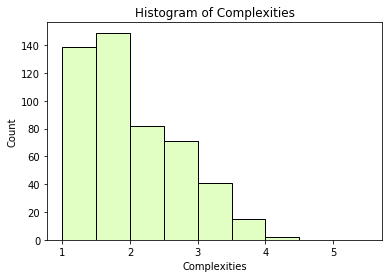

In [92]:
n, bins, patches = pyplot.hist(game_data['Complexity'], bins=np.arange(1,6, 0.5), color='#e1ffc3', edgecolor='#000000')
pyplot.xlabel('Complexities')
pyplot.ylabel('Count')
pyplot.title('Histogram of Complexities')

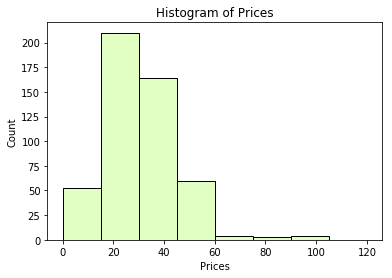

In [85]:
n, bins, patches = pyplot.hist(game_data['Price'], bins=[0,15,30,45,60,75,90,105,120], color='#e1ffc3', edgecolor='#000000')
pyplot.xlabel('Prices')
pyplot.ylabel('Count')
pyplot.title('Histogram of Prices')